In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import pandas as pd
from PIL import Image
import os
import pydicom as dicom

# Dataset extraction

In [3]:
targets = []
features = []

folder_path = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean"

files = os.listdir(folder_path)

for file in files:
    print(file)
    file_path = os.path.join(folder_path, file) # join the folder_path and the file name to get the file_path
    img = dicom.read_file(file_path) #read dicom image
    img_array = img.pixel_array #get image array
    img_from_array = Image.fromarray(img_array) #convert array to PIL.Image
    img_resize = img_from_array.resize((75,75),resample=Image.NEAREST) #resize the image
    img_resize_array = np.asarray(img_resize) #convert PIL.Image to np.array
    
    data_table = pd.read_excel('D:\DataSet\CCMD_BreastCancer\CMMD_clinicaldata_revision.xlsx', index_col=0, engine='openpyxl')
    
    side = img.ImageLaterality
    fileId = file[0:7]
    
    if ((data_table.index == fileId).sum()) != 0: #check if the fileId is in the data_table
        
        # check if there is data for the corresponding breast side of the picture
        if (data_table[(data_table['LeftRight']==side) & (data_table.index==fileId)].index.value_counts().values) > 0:
            features.append(img_resize_array) #append the np.array to features
            
            print(data_table.query('id==@fileId & LeftRight==@side')['classification'].item())
            
            if data_table.query('id==@fileId & LeftRight==@side')['classification'].item() == 'Benign':
                target = [0]
                targets.append(target)

            elif data_table.query('id==@fileId & LeftRight==@side')['classification'].item() == 'Malignant':
                target = [1]
                targets.append(target)
    
    
features = np.array(features)
targets = np.array(targets)
print("Features shape :", features.shape)
print("Targets shape :", targets.shape)

D1-0001_0.dcm
Benign
D1-0001_1.dcm
Benign
D1-0002_0.dcm
Benign
D1-0002_1.dcm
Benign
D1-0003_0.dcm
Benign
D1-0003_1.dcm
Benign
D1-0004_0.dcm
Benign
D1-0004_1.dcm
Benign
D1-0005_0.dcm
Benign
D1-0005_1.dcm
Benign
D1-0006_0.dcm
Benign
D1-0006_1.dcm
Benign
D1-0007_0.dcm
Benign
D1-0007_1.dcm
Benign
D1-0008_0.dcm
Benign
D1-0008_1.dcm
Benign
D1-0009_0.dcm
Benign
D1-0009_1.dcm
Benign
D1-0010_0.dcm
Benign
D1-0010_1.dcm
Benign
D1-0011_0.dcm
Benign
D1-0011_1.dcm
Benign
D1-0012_0.dcm
Benign
D1-0012_1.dcm
Benign
D1-0013_0.dcm
Benign
D1-0013_1.dcm
Benign
D1-0014_0.dcm
Benign
D1-0014_1.dcm
Benign
D1-0015_0.dcm
Benign
D1-0015_1.dcm
Benign
D1-0016_0.dcm
Benign
D1-0016_1.dcm
Benign
D1-0017_0.dcm
Benign
D1-0017_1.dcm
Benign
D1-0018_0.dcm
Benign
D1-0018_1.dcm
Benign
D1-0019_0.dcm
Benign
D1-0019_1.dcm
Benign
D1-0020_0.dcm
Benign
D1-0020_1.dcm
Benign
D1-0021_0.dcm
Benign
D1-0021_1.dcm
Benign
D1-0021_2.dcm
Benign
D1-0021_3.dcm
Benign
D1-0022_0.dcm
Benign
D1-0022_1.dcm
Benign
D1-0023_0.dcm
Benign
D1-0023_1.dcm

Benign
D1-0260_0.dcm
Benign
D1-0260_1.dcm
Benign
D1-0261_0.dcm
Benign
D1-0261_1.dcm
Benign
D1-0262_0.dcm
Benign
D1-0262_1.dcm
Benign
D1-0263_0.dcm
Benign
D1-0263_1.dcm
Benign
D1-0263_2.dcm
Benign
D1-0263_3.dcm
Benign
D1-0264_0.dcm
Benign
D1-0264_1.dcm
Benign
D1-0265_0.dcm
Benign
D1-0265_1.dcm
Benign
D1-0266_0.dcm
Benign
D1-0266_1.dcm
Benign
D1-0267_0.dcm
Benign
D1-0267_1.dcm
Benign
D1-0268_0.dcm
Benign
D1-0268_1.dcm
Benign
D1-0269_0.dcm
Benign
D1-0269_1.dcm
Benign
D1-0270_0.dcm
Benign
D1-0270_1.dcm
Benign
D1-0271_0.dcm
Benign
D1-0271_1.dcm
Benign
D1-0272_0.dcm
Benign
D1-0272_1.dcm
Benign
D1-0273_0.dcm
Benign
D1-0273_1.dcm
Benign
D1-0273_2.dcm
Benign
D1-0273_3.dcm
Benign
D1-0274_0.dcm
Benign
D1-0274_1.dcm
Benign
D1-0274_2.dcm
Benign
D1-0274_3.dcm
Benign
D1-0275_0.dcm
Benign
D1-0275_1.dcm
Benign
D1-0275_2.dcm
Benign
D1-0275_3.dcm
Benign
D1-0276_0.dcm
Benign
D1-0276_1.dcm
Benign
D1-0277_0.dcm
Benign
D1-0277_1.dcm
Benign
D1-0278_0.dcm
Benign
D1-0278_1.dcm
Benign
D1-0279_0.dcm
Benign
D1-027

Malignant
D1-0624_1.dcm
Malignant
D1-0631_0.dcm
Malignant
D1-0631_1.dcm
Malignant
D1-0633_0.dcm
Malignant
D1-0633_1.dcm
Malignant
D1-0636_0.dcm
Malignant
D1-0636_1.dcm
Malignant
D1-0637_0.dcm
Malignant
D1-0637_1.dcm
Malignant
D1-0639_0.dcm
Malignant
D1-0639_1.dcm
Malignant
D1-0641_0.dcm
Malignant
D1-0641_1.dcm
Malignant
D1-0642_0.dcm
Malignant
D1-0642_1.dcm
Malignant
D1-0647_0.dcm
Malignant
D1-0647_1.dcm
Malignant
D1-0649_0.dcm
Malignant
D1-0649_1.dcm
Malignant
D1-0653_0.dcm
Malignant
D1-0653_1.dcm
Malignant
D1-0656_0.dcm
Malignant
D1-0656_1.dcm
Malignant
D1-0658_0.dcm
Malignant
D1-0658_1.dcm
Malignant
D1-0662_0.dcm
Malignant
D1-0662_1.dcm
Malignant
D1-0663_0.dcm
Malignant
D1-0663_1.dcm
Malignant
D1-0664_0.dcm
Malignant
D1-0664_1.dcm
Malignant
D1-0666_0.dcm
Malignant
D1-0666_1.dcm
Malignant
D1-0666_2.dcm
Malignant
D1-0666_3.dcm
Malignant
D1-0667_0.dcm
Malignant
D1-0667_1.dcm
Malignant
D1-0672_0.dcm
Malignant
D1-0672_1.dcm
Malignant
D1-0677_0.dcm
Malignant
D1-0677_1.dcm
Malignant
D1-067

Benign
D1-0832_1.dcm
Benign
D1-0833_0.dcm
Benign
D1-0833_1.dcm
Benign
D1-0834_0.dcm
Benign
D1-0834_1.dcm
Benign
D1-0835_0.dcm
Benign
D1-0835_1.dcm
Benign
D1-0836_0.dcm
Benign
D1-0836_1.dcm
Benign
D1-0837_0.dcm
Benign
D1-0837_1.dcm
Benign
D1-0838_0.dcm
Benign
D1-0838_1.dcm
Benign
D1-0839_0.dcm
Benign
D1-0839_1.dcm
Benign
D1-0840_0.dcm
Benign
D1-0840_1.dcm
Benign
D1-0841_0.dcm
Benign
D1-0841_1.dcm
Benign
D1-0842_0.dcm
Benign
D1-0842_1.dcm
Benign
D1-0843_0.dcm
Benign
D1-0843_1.dcm
Benign
D1-0844_0.dcm
Benign
D1-0844_1.dcm
Benign
D1-0845_0.dcm
Benign
D1-0845_1.dcm
Benign
D1-0845_2.dcm
Benign
D1-0845_3.dcm
Benign
D1-0846_0.dcm
Benign
D1-0846_1.dcm
Benign
D1-0847_0.dcm
Benign
D1-0847_1.dcm
Benign
D1-0848_0.dcm
Benign
D1-0848_1.dcm
Benign
D1-0849_0.dcm
Benign
D1-0849_1.dcm
Benign
D1-0850_0.dcm
Benign
D1-0850_1.dcm
Benign
D1-0851_0.dcm
Benign
D1-0851_1.dcm
Benign
D1-0852_0.dcm
Benign
D1-0852_1.dcm
Benign
D1-0853_0.dcm
Benign
D1-0853_1.dcm
Benign
D1-0853_2.dcm
Benign
D1-0853_3.dcm
Benign
D1-085

Benign
D1-1006_0.dcm
Benign
D1-1006_1.dcm
Benign
D1-1007_0.dcm
Benign
D1-1007_1.dcm
Benign
D1-1008_0.dcm
Benign
D1-1008_1.dcm
Benign
D1-1009_0.dcm
Benign
D1-1009_1.dcm
Benign
D1-1009_2.dcm
Benign
D1-1009_3.dcm
Benign
D1-1010_0.dcm
Benign
D1-1010_1.dcm
Benign
D1-1011_0.dcm
Benign
D1-1011_1.dcm
Benign
D1-1012_0.dcm
Benign
D1-1012_1.dcm
Benign
D1-1013_0.dcm
Benign
D1-1013_1.dcm
Benign
D1-1014_0.dcm
Benign
D1-1014_1.dcm
Benign
D1-1015_0.dcm
Benign
D1-1015_1.dcm
Benign
D1-1016_0.dcm
Benign
D1-1016_1.dcm
Benign
D1-1017_0.dcm
Benign
D1-1017_1.dcm
Benign
D1-1018_0.dcm
Benign
D1-1018_1.dcm
Benign
D1-1019_0.dcm
Benign
D1-1019_1.dcm
Benign
D1-1020_0.dcm
Benign
D1-1020_1.dcm
Benign
D1-1021_0.dcm
Benign
D1-1021_1.dcm
Benign
D1-1022_0.dcm
Benign
D1-1022_1.dcm
Benign
D1-1023_0.dcm
Benign
D1-1023_1.dcm
Benign
D1-1024_0.dcm
Benign
D1-1024_1.dcm
Benign
D1-1025_0.dcm
Benign
D1-1025_1.dcm
Benign
D1-1026_0.dcm
Benign
D1-1026_1.dcm
Benign
D1-1027_0.dcm
Benign
D1-1027_1.dcm
Benign
D1-1028_0.dcm
Benign
D1-102

Malignant
D1-1347_0.dcm
Malignant
D1-1347_1.dcm
Malignant
D1-1349_0.dcm
Malignant
D1-1349_1.dcm
Malignant
D1-1351_0.dcm
Malignant
D1-1351_1.dcm
Malignant
D1-1355_0.dcm
Malignant
D1-1355_1.dcm
Malignant
D1-1357_0.dcm
Malignant
D1-1357_1.dcm
Malignant
D1-1359_0.dcm
Malignant
D1-1359_1.dcm
Malignant
D1-1362_0.dcm
Malignant
D1-1362_1.dcm
Malignant
D1-1364_0.dcm
Malignant
D1-1364_1.dcm
Malignant
D1-1366_0.dcm
Malignant
D1-1366_1.dcm
Malignant
D1-1367_0.dcm
Malignant
D1-1367_1.dcm
Malignant
D1-1373_0.dcm
Malignant
D1-1373_1.dcm
Malignant
D1-1375_0.dcm
Malignant
D1-1375_1.dcm
Malignant
D1-1376_0.dcm
Malignant
D1-1376_1.dcm
Malignant
D1-1377_0.dcm
Malignant
D1-1377_1.dcm
Malignant
D1-1379_0.dcm
Malignant
D1-1379_1.dcm
Malignant
D1-1380_0.dcm
Malignant
D1-1380_1.dcm
Malignant
D1-1381_0.dcm
Malignant
D1-1381_1.dcm
Malignant
D1-1384_0.dcm
Malignant
D1-1384_1.dcm
Malignant
D1-1392_0.dcm
Malignant
D1-1392_1.dcm
Malignant
D1-1393_0.dcm
Malignant
D1-1393_1.dcm
Malignant
D1-1395_0.dcm
Malignant
D1-139

Malignant
D1-1750_0.dcm
Malignant
D1-1750_1.dcm
Malignant
D1-1751_0.dcm
Malignant
D1-1751_1.dcm
Malignant
D1-1752_0.dcm
Malignant
D1-1752_1.dcm
Malignant
D1-1753_0.dcm
Malignant
D1-1753_1.dcm
Malignant
D1-1756_0.dcm
Malignant
D1-1756_1.dcm
Malignant
D1-1757_0.dcm
Malignant
D1-1757_1.dcm
Malignant
D1-1758_0.dcm
Malignant
D1-1758_1.dcm
Malignant
D1-1761_0.dcm
Malignant
D1-1761_1.dcm
Malignant
D1-1765_0.dcm
Malignant
D1-1765_1.dcm
Malignant
D1-1766_0.dcm
Malignant
D1-1766_1.dcm
Malignant
D1-1768_0.dcm
Malignant
D1-1768_1.dcm
Malignant
D1-1769_0.dcm
Malignant
D1-1769_1.dcm
Malignant
D1-1771_0.dcm
Malignant
D1-1771_1.dcm
Malignant
D1-1775_0.dcm
Malignant
D1-1775_1.dcm
Malignant
D2-0001_0.dcm
Malignant
D2-0001_1.dcm
Malignant
D2-0001_2.dcm


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


D2-0001_3.dcm
D2-0002_0.dcm
D2-0002_1.dcm
D2-0002_2.dcm
Malignant
D2-0002_3.dcm
Malignant
D2-0003_0.dcm
Malignant
D2-0003_1.dcm
Malignant
D2-0003_2.dcm
D2-0003_3.dcm
D2-0004_0.dcm
Malignant
D2-0004_1.dcm
Malignant
D2-0004_2.dcm
D2-0004_3.dcm
D2-0005_0.dcm
D2-0005_1.dcm
D2-0005_2.dcm
Malignant
D2-0005_3.dcm
Malignant
D2-0006_0.dcm
D2-0006_1.dcm
D2-0006_2.dcm
Malignant
D2-0006_3.dcm
Malignant
D2-0007_0.dcm
D2-0007_1.dcm
D2-0007_2.dcm
Malignant
D2-0007_3.dcm
Malignant
D2-0008_0.dcm
D2-0008_1.dcm
D2-0008_2.dcm
Malignant
D2-0008_3.dcm
Malignant
D2-0009_0.dcm
D2-0009_1.dcm
D2-0009_2.dcm
Malignant
D2-0009_3.dcm
Malignant
D2-0010_0.dcm
D2-0010_1.dcm
D2-0010_2.dcm
Malignant
D2-0010_3.dcm
Malignant
D2-0011_0.dcm
D2-0011_1.dcm
D2-0011_2.dcm
Malignant
D2-0011_3.dcm
Malignant
D2-0012_0.dcm
Malignant
D2-0012_1.dcm
Malignant
D2-0012_2.dcm
D2-0012_3.dcm
D2-0013_0.dcm
Malignant
D2-0013_1.dcm
Malignant
D2-0013_2.dcm
D2-0013_3.dcm
D2-0014_0.dcm
Malignant
D2-0014_1.dcm
Malignant
D2-0014_2.dcm
D2-0014_3.dc

D2-0108_3.dcm
D2-0109_0.dcm
Malignant
D2-0109_1.dcm
Malignant
D2-0109_2.dcm
D2-0109_3.dcm
D2-0110_0.dcm
Malignant
D2-0110_1.dcm
Malignant
D2-0110_2.dcm
D2-0110_3.dcm
D2-0111_0.dcm
Malignant
D2-0111_1.dcm
Malignant
D2-0111_2.dcm
D2-0111_3.dcm
D2-0112_0.dcm
D2-0112_1.dcm
D2-0112_2.dcm
Malignant
D2-0112_3.dcm
Malignant
D2-0113_0.dcm
D2-0113_1.dcm
D2-0113_2.dcm
Malignant
D2-0113_3.dcm
Malignant
D2-0114_0.dcm
Malignant
D2-0114_1.dcm
Malignant
D2-0114_2.dcm
D2-0114_3.dcm
D2-0115_0.dcm
Malignant
D2-0115_1.dcm
Malignant
D2-0115_2.dcm
D2-0115_3.dcm
D2-0116_0.dcm
Malignant
D2-0116_1.dcm
Malignant
D2-0116_2.dcm
D2-0116_3.dcm
D2-0117_0.dcm
Malignant
D2-0117_1.dcm
Malignant
D2-0117_2.dcm
D2-0117_3.dcm
D2-0118_0.dcm
D2-0118_1.dcm
D2-0118_2.dcm
Malignant
D2-0118_3.dcm
Malignant
D2-0119_0.dcm
D2-0119_1.dcm
D2-0119_2.dcm
Malignant
D2-0119_3.dcm
Malignant
D2-0120_0.dcm
D2-0120_1.dcm
D2-0120_2.dcm
Malignant
D2-0120_3.dcm
Malignant
D2-0121_0.dcm
Malignant
D2-0121_1.dcm
Malignant
D2-0121_2.dcm
D2-0121_3.dc

D2-0216_3.dcm
D2-0217_0.dcm
D2-0217_1.dcm
D2-0217_2.dcm
Malignant
D2-0217_3.dcm
Malignant
D2-0218_0.dcm
D2-0218_1.dcm
D2-0218_2.dcm
Malignant
D2-0218_3.dcm
Malignant
D2-0219_0.dcm
D2-0219_1.dcm
D2-0219_2.dcm
Malignant
D2-0219_3.dcm
Malignant
D2-0220_0.dcm
Malignant
D2-0220_1.dcm
Malignant
D2-0220_2.dcm
Malignant
D2-0220_3.dcm
Malignant
D2-0221_0.dcm
Malignant
D2-0221_1.dcm
Malignant
D2-0221_2.dcm
D2-0221_3.dcm
D2-0222_0.dcm
Malignant
D2-0222_1.dcm
Malignant
D2-0222_2.dcm
D2-0222_3.dcm
D2-0223_0.dcm
D2-0223_1.dcm
D2-0223_2.dcm
Malignant
D2-0223_3.dcm
Malignant
D2-0224_0.dcm
D2-0224_1.dcm
D2-0224_2.dcm
Malignant
D2-0224_3.dcm
Malignant
D2-0225_0.dcm
D2-0225_1.dcm
D2-0225_2.dcm
Malignant
D2-0225_3.dcm
Malignant
D2-0226_0.dcm
D2-0226_1.dcm
D2-0226_2.dcm
Malignant
D2-0226_3.dcm
Malignant
D2-0227_0.dcm
D2-0227_1.dcm
D2-0227_2.dcm
Malignant
D2-0227_3.dcm
Malignant
D2-0228_0.dcm
Malignant
D2-0228_1.dcm
Malignant
D2-0228_2.dcm
D2-0228_3.dcm
D2-0229_0.dcm
D2-0229_1.dcm
D2-0229_2.dcm
Malignant
D2

D2-0324_3.dcm
D2-0325_0.dcm
Malignant
D2-0325_1.dcm
Malignant
D2-0325_2.dcm
D2-0325_3.dcm
D2-0326_0.dcm
Malignant
D2-0326_1.dcm
Malignant
D2-0326_2.dcm
D2-0326_3.dcm
D2-0327_0.dcm
Malignant
D2-0327_1.dcm
Malignant
D2-0327_2.dcm
D2-0327_3.dcm
D2-0328_0.dcm
Malignant
D2-0328_1.dcm
Malignant
D2-0328_2.dcm
D2-0328_3.dcm
D2-0329_0.dcm
D2-0329_1.dcm
D2-0329_2.dcm
Malignant
D2-0329_3.dcm
Malignant
D2-0330_0.dcm
Malignant
D2-0330_1.dcm
Malignant
D2-0330_2.dcm
D2-0330_3.dcm
D2-0331_0.dcm
D2-0331_1.dcm
D2-0331_2.dcm
Malignant
D2-0331_3.dcm
Malignant
D2-0332_0.dcm
Malignant
D2-0332_1.dcm
Malignant
D2-0332_2.dcm
D2-0332_3.dcm
D2-0333_0.dcm
D2-0333_1.dcm
D2-0333_2.dcm
Malignant
D2-0333_3.dcm
Malignant
D2-0334_0.dcm
Malignant
D2-0334_1.dcm
Malignant
D2-0334_2.dcm
D2-0334_3.dcm
D2-0335_0.dcm
D2-0335_1.dcm
D2-0335_2.dcm
Malignant
D2-0335_3.dcm
Malignant
D2-0336_0.dcm
D2-0336_1.dcm
D2-0336_2.dcm
Malignant
D2-0336_3.dcm
Malignant
D2-0337_0.dcm
D2-0337_1.dcm
D2-0337_2.dcm
Malignant
D2-0337_3.dcm
Malignan

Malignant
D2-0433_0.dcm
Malignant
D2-0433_1.dcm
Malignant
D2-0433_2.dcm
D2-0433_3.dcm
D2-0434_0.dcm
D2-0434_1.dcm
D2-0434_2.dcm
Malignant
D2-0434_3.dcm
Malignant
D2-0435_0.dcm
Malignant
D2-0435_1.dcm
Malignant
D2-0435_2.dcm
D2-0435_3.dcm
D2-0436_0.dcm
Malignant
D2-0436_1.dcm
Malignant
D2-0436_2.dcm
D2-0436_3.dcm
D2-0437_0.dcm
Malignant
D2-0437_1.dcm
Malignant
D2-0437_2.dcm
D2-0437_3.dcm
D2-0438_0.dcm
D2-0438_1.dcm
D2-0438_2.dcm
Malignant
D2-0438_3.dcm
Malignant
D2-0439_0.dcm
Malignant
D2-0439_1.dcm
Malignant
D2-0439_2.dcm
D2-0439_3.dcm
D2-0440_0.dcm
Malignant
D2-0440_1.dcm
Malignant
D2-0440_2.dcm
D2-0440_3.dcm
D2-0441_0.dcm
Malignant
D2-0441_1.dcm
Malignant
D2-0441_2.dcm
D2-0441_3.dcm
D2-0442_0.dcm
Malignant
D2-0442_1.dcm
Malignant
D2-0442_2.dcm
D2-0442_3.dcm
D2-0443_0.dcm
Malignant
D2-0443_1.dcm
Malignant
D2-0443_2.dcm
D2-0443_3.dcm
D2-0444_0.dcm
Malignant
D2-0444_1.dcm
Malignant
D2-0444_2.dcm
D2-0444_3.dcm
D2-0445_0.dcm
D2-0445_1.dcm
D2-0445_2.dcm
Malignant
D2-0445_3.dcm
Malignant
D2

D2-0540_3.dcm
D2-0541_0.dcm
Malignant
D2-0541_1.dcm
Malignant
D2-0541_2.dcm
D2-0541_3.dcm
D2-0542_0.dcm
Malignant
D2-0542_1.dcm
Malignant
D2-0542_2.dcm
D2-0542_3.dcm
D2-0543_0.dcm
Malignant
D2-0543_1.dcm
Malignant
D2-0543_2.dcm
D2-0543_3.dcm
D2-0544_0.dcm
D2-0544_1.dcm
D2-0544_2.dcm
Malignant
D2-0544_3.dcm
Malignant
D2-0545_0.dcm
D2-0545_1.dcm
D2-0545_2.dcm
Malignant
D2-0545_3.dcm
Malignant
D2-0546_0.dcm
Malignant
D2-0546_1.dcm
Malignant
D2-0546_2.dcm
D2-0546_3.dcm
D2-0547_0.dcm
D2-0547_1.dcm
D2-0547_2.dcm
Malignant
D2-0547_3.dcm
Malignant
D2-0548_0.dcm
Malignant
D2-0548_1.dcm
Malignant
D2-0548_2.dcm
D2-0548_3.dcm
D2-0549_0.dcm
Malignant
D2-0549_1.dcm
Malignant
D2-0549_2.dcm
D2-0549_3.dcm
D2-0550_0.dcm
D2-0550_1.dcm
D2-0550_2.dcm
Malignant
D2-0550_3.dcm
Malignant
D2-0551_0.dcm
D2-0551_1.dcm
D2-0551_2.dcm
Malignant
D2-0551_3.dcm
Malignant
D2-0552_0.dcm
D2-0552_1.dcm
D2-0552_2.dcm
Malignant
D2-0552_3.dcm
Malignant
D2-0553_0.dcm
D2-0553_1.dcm
D2-0553_2.dcm
Malignant
D2-0553_3.dcm
Malignan

Malignant
D2-0648_1.dcm
Malignant
D2-0648_2.dcm
D2-0648_3.dcm
D2-0649_0.dcm
D2-0649_1.dcm
D2-0649_2.dcm
Malignant
D2-0649_3.dcm
Malignant
D2-0650_0.dcm
D2-0650_1.dcm
D2-0650_2.dcm
Malignant
D2-0650_3.dcm
Malignant
D2-0651_0.dcm
Malignant
D2-0651_1.dcm
Malignant
D2-0651_2.dcm
D2-0651_3.dcm
D2-0652_0.dcm
Malignant
D2-0652_1.dcm
Malignant
D2-0652_2.dcm
D2-0652_3.dcm
D2-0653_0.dcm
D2-0653_1.dcm
D2-0653_2.dcm
Malignant
D2-0653_3.dcm
Malignant
D2-0654_0.dcm
Malignant
D2-0654_1.dcm
Malignant
D2-0654_2.dcm
D2-0654_3.dcm
D2-0655_0.dcm
Malignant
D2-0655_1.dcm
Malignant
D2-0655_2.dcm
D2-0655_3.dcm
D2-0656_0.dcm
D2-0656_1.dcm
D2-0656_2.dcm
Malignant
D2-0656_3.dcm
Malignant
D2-0657_0.dcm
D2-0657_1.dcm
D2-0657_2.dcm
Malignant
D2-0657_3.dcm
Malignant
D2-0658_0.dcm
Malignant
D2-0658_1.dcm
Malignant
D2-0658_2.dcm
D2-0658_3.dcm
D2-0659_0.dcm
Malignant
D2-0659_1.dcm
Malignant
D2-0659_2.dcm
D2-0659_3.dcm
D2-0660_0.dcm
D2-0660_1.dcm
D2-0660_2.dcm
Malignant
D2-0660_3.dcm
Malignant
D2-0661_0.dcm
D2-0661_1.dc

# Test / Validation dataset split 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.1, random_state=42)

X_train = np.expand_dims(X_train, -1) # features need to have a matrice size(x,x,x,1)
X_valid = np.expand_dims(X_valid, -1)

print("X_train", X_train.shape)
print("X_valid", X_valid.shape)
print("y_train", y_train.shape)
print("y_valid", y_valid.shape)

X_train (3369, 75, 75, 1)
X_valid (375, 75, 75, 1)
y_train (3369, 1)
y_valid (375, 1)


# Model creation

In [162]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(75,75,1), name="conv_layer1"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='relu', name="conv_layer2"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation='relu', name="conv_layer3"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation='relu', name="conv_layer4"))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 73, 73, 32)        320       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv_layer4 (Conv2D)         (None, 5, 5, 256)       

# Model Fit

In [163]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

Train on 3369 samples, validate on 375 samples
Epoch 1/10
3369/3369 [==============================] - 11s 3ms/sample - loss: 0.6159 - accuracy: 0.6969 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 2/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6065 - accuracy: 0.7067 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 3/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6065 - accuracy: 0.7067 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 4/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6065 - accuracy: 0.7067 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 5/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6065 - accuracy: 0.7067 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 6/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6065 - accuracy: 0.7067 - val_loss: 0.6439 - val_accuracy: 0.6693
Epoch 7/10
3369/3369 [==============================] - 10s 3ms/sample 

# Evaluate Model

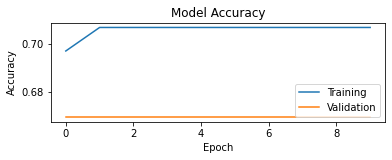

In [178]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Display Filters

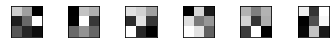

In [165]:
filters, biases = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 6, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
        
# show the figure
plt.show()

We can see from the pictures above what the first 6 filters of the first convolution layer look like. 

# Display feature map

In [166]:
layer_outputs = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

image_path= r"D:\DataSet\CCMD_BreastCancer\Dataset_Clean _Copy\D1-1498_0.jpg"
img = Image.open(image_path).resize((75,75),resample=Image.NEAREST)
img_array = np.asarray(img)

img_array = np.expand_dims(img_array, (-1,0))
input_img = img_array/255.0
print(input_img.shape)

(1, 75, 75, 1)


In [167]:
feature_maps = feature_map_model.predict(input_img)

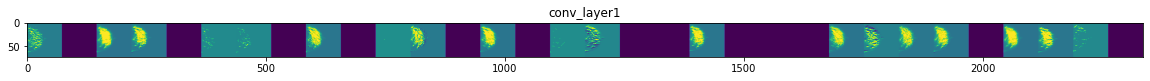

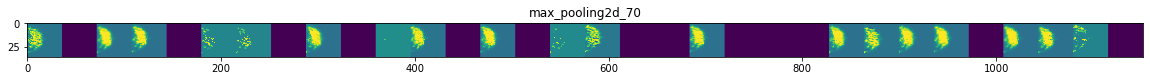

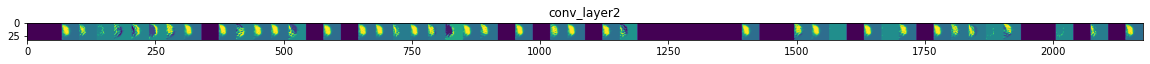

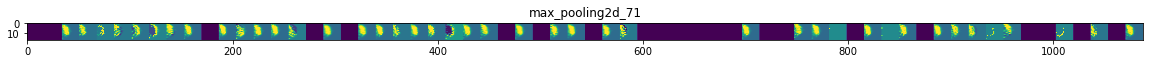

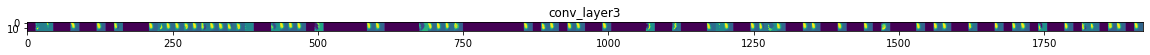

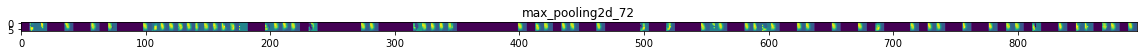

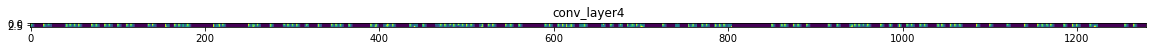

In [177]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]  
        size = feature_map.shape[1]
        
        display_grid = np.zeros((size, size * k))
        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std ()
            feature_image *=  64
            feature_image += 128
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = feature_image
        
        # Display the grid
        scale = 20. / k
        plt.figure( figsize=(scale * k, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto')

# Test part :

In [27]:
filepath = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean\D1-0021_0.dcm"
img = dicom.dcmread(filepath) #read the dcm file
print(img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital Mammography X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1239.1759.688928500915688097475664961311
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20170818'
(0008, 0013) Instance Creation Time              TM: '114701'
(000

In [90]:
path_test = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean\D1-0021_0.dcm"

df = pd.read_excel('D:\DataSet\CCMD_BreastCancer\CMMD_clinicaldata_revision.xlsx', index_col=0, engine='openpyxl')
    
print(data_table[18:25])

fileId = 'D1-0021'
side = 'R'

#print((data_table.index == 'D1-0021').sum())

if ((df.index == 'D1-0021').sum()) != 0: #check if the fileId is in the data_table
    # check if there is data for the specific side of the picture
    if (df[(df['LeftRight']=='R') & (df.index=='D1-0021')].index.value_counts().values) != 0:
        print("ok")

        LeftRight  Age  number    abnormality classification subtype
id                                                                  
D1-0019         L   44       2  calcification         Benign     NaN
D1-0020         R   53       2  calcification         Benign     NaN
D1-0021         L   22       2  calcification         Benign     NaN
D1-0021         R   22       2  calcification         Benign     NaN
D1-0022         L   34       2  calcification         Benign     NaN
D1-0023         R   48       2  calcification         Benign     NaN
D1-0024         R   33       2  calcification         Benign     NaN
ok


In [29]:
fileId = 'D1-0021'

if fileId in data_table:
    print("True")